In [2]:
# --- 1. Setup Environment ---
!pip uninstall -y jax jaxlib tensorflow flax -q
!pip install -U transformers datasets evaluate accelerate codecarbon -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 93.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 41.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00

In [3]:
# --- 2. Imports ---
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
import torch
from codecarbon import EmissionsTracker


In [4]:
# --- 3. Load Dataset (IMDB for Sentiment Classification) ---
dataset = load_dataset("imdb")


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# --- 4. Load Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model_checkpoint = "distilbert-base-uncased"  # or "microsoft/MiniLM-L6-H384-uncased"

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
# --- 5. Train/Test Split ---
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))


In [7]:
# --- 6. Define Model ---
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# --- 7. Define Metric (Accuracy) ---
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [9]:
# --- 8. TrainingArguments ---
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"  # disables wandb etc.
)

In [10]:
# --- 9. Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipykernel_36/2457266571.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
# --- 10. Track Energy with CodeCarbon ---
tracker = EmissionsTracker(output_dir="./", output_file="emissions.csv")
tracker.start()

trainer.train()
results = trainer.evaluate()

tracker.stop()


[codecarbon WARNING @ 14:40:53] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:40:53] [setup] RAM Tracking...
[codecarbon INFO @ 14:40:53] [setup] CPU Tracking...
[codecarbon WARNING @ 14:40:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:40:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:40:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 14:40:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:40:54] [setup] GPU Tracking...
[codecarbon INFO @ 14:40:54] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:40:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch,Training Loss,Validation Loss,Accuracy
1,0.318600,0.309176,0.866500
2,0.204400,0.294786,0.880500
3,0.135500,0.307434,0.896500
4,0.090300,0.328383,0.892500


[codecarbon INFO @ 14:41:12] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:41:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:41:12] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 14:41:12] Energy consumed for all GPUs : 0.000489 kWh. Total GPU Power : 117.18756683079312 W
[codecarbon INFO @ 14:41:12] 0.000749 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:27] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:41:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:41:27] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 14:41:27] Energy consumed for all GPUs : 0.001025 kWh. Total GPU Power : 128.7111417168948 W
[codecarbon INFO @ 14:41:27] 0.001545 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:42] Energy consumed for RAM : 0.000250 kWh. RAM Power : 

[codecarbon INFO @ 14:45:57] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:45:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:45:57] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 14:45:57] Energy consumed for all GPUs : 0.010769 kWh. Total GPU Power : 133.05792568751383 W
[codecarbon INFO @ 14:45:57] 0.015974 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:45:58] Energy consumed for RAM : 0.001669 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:45:58] Delta energy consumed for CPU with constant : 0.000007 kWh, power : 42.5 W
[codecarbon INFO @ 14:45:58] Energy consumed for All CPU : 0.003546 kWh
[codecarbon INFO @ 14:45:58] Energy consumed for all GPUs : 0.010789 kWh. Total GPU Power : 129.50406166096636 W
[codecarbon INFO @ 14:45:58] 0.016004 kWh of electricity used since the beginning.


0.0072436531116735255

In [12]:
# --- 11. Show Results ---
print("Final Accuracy:", results["eval_accuracy"])
print("CodeCarbon log saved to emissions.csv")

Final Accuracy: 0.8925
CodeCarbon log saved to emissions.csv


In [13]:
# --- Experiment: Gradient Checkpointing (memory-efficient fine-tuning) ---
model.gradient_checkpointing_enable()

training_args.num_train_epochs = 4
training_args.gradient_accumulation_steps = 2  # simulate larger batch

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

tracker = EmissionsTracker(output_dir="./", output_file="emissions_checkpointing.csv")
tracker.start()
trainer.train()
gc_results = trainer.evaluate()
tracker.stop()

print("GC Accuracy:", gc_results["eval_accuracy"])


/tmp/ipykernel_36/2236799721.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon WARNING @ 14:45:58] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:45:58] [setup] RAM Tracking...
[codecarbon INFO @ 14:45:58] [setup] CPU Tracking...
[codecarbon WARNING @ 14:45:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:45:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:45:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 14:45:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:45:59] [setup] GPU Tracking...
[codec

Epoch,Training Loss,Validation Loss,Accuracy
1,0.098900,0.388128,0.891000
2,0.044000,0.466848,0.889000
3,0.036500,0.461367,0.890000
4,0.022100,0.481926,0.893000


[codecarbon INFO @ 14:46:17] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:46:17] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 14:46:17] Energy consumed for all GPUs : 0.000513 kWh. Total GPU Power : 122.96771516359422 W
[codecarbon INFO @ 14:46:17] 0.000773 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:32] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:46:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:46:32] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 14:46:32] Energy consumed for all GPUs : 0.001037 kWh. Total GPU Power : 125.86242502755873 W
[codecarbon INFO @ 14:46:32] 0.001558 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:46:47] Energy consumed for RAM : 0.000250 kWh. RAM Power :

[codecarbon INFO @ 14:55:58] Energy consumed for RAM : 0.003309 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:55:58] Delta energy consumed for CPU with constant : 0.000131 kWh, power : 42.5 W
[codecarbon INFO @ 14:55:58] Energy consumed for All CPU : 0.007032 kWh
[codecarbon INFO @ 14:55:58] Energy consumed for all GPUs : 0.020999 kWh. Total GPU Power : 132.73734839288687 W
[codecarbon INFO @ 14:55:58] 0.031340 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:58] 0.023890 g.CO2eq/s mean an estimation of 753.393305528413 kg.CO2eq/year


GC Accuracy: 0.893


In [14]:
# --- Experiment: Mixed Precision (fp16) Training ---

from transformers import TrainingArguments, Trainer
from codecarbon import EmissionsTracker

# Enable mixed precision
training_args_fp16 = TrainingArguments(
    output_dir="./results_fp16",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs_fp16",
    logging_steps=50,
    report_to="none",
    fp16=True  # enable mixed precision
)

# Reuse your model (baseline DistilBERT)
model_fp16 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

trainer_fp16 = Trainer(
    model=model_fp16,
    args=training_args_fp16,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Track emissions
tracker_fp16 = EmissionsTracker(output_dir="./", output_file="emissions_fp16.csv")
tracker_fp16.start()

trainer_fp16.train()
fp16_results = trainer_fp16.evaluate()

tracker_fp16.stop()

# Save results to CSV
import pandas as pd
pd.DataFrame([{
    "Experiment": "Mixed Precision (fp16)",
    "Accuracy": fp16_results["eval_accuracy"],
    "Validation Loss": fp16_results["eval_loss"]
}]).to_csv("results_fp16_summary.csv", index=False)

print("Mixed Precision Accuracy:", fp16_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/360367928.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fp16 = Trainer(
[codecarbon WARNING @ 14:55:58] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:55:58] [setup] RAM Tracking...
[codecarbon INFO @ 14:55:58] [setup] CPU Tracking...
[codecarbon WARNING @ 14:56:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:56:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.327500,0.347784,0.850000
2,0.209200,0.320509,0.873000
3,0.141200,0.302692,0.899500
4,0.091200,0.325776,0.892000


[codecarbon INFO @ 14:56:18] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:56:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:56:18] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 14:56:18] Energy consumed for all GPUs : 0.000535 kWh. Total GPU Power : 128.3644075555239 W
[codecarbon INFO @ 14:56:18] 0.000796 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:33] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 14:56:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:56:33] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 14:56:33] Energy consumed for all GPUs : 0.001076 kWh. Total GPU Power : 129.98470082423012 W
[codecarbon INFO @ 14:56:33] 0.001597 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:48] Energy consumed for RAM : 0.000250 kWh. RAM Power : 

[codecarbon INFO @ 15:01:16] Energy consumed for RAM : 0.001740 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:01:16] Delta energy consumed for CPU with constant : 0.000159 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:16] Energy consumed for All CPU : 0.003699 kWh
[codecarbon INFO @ 15:01:16] Energy consumed for all GPUs : 0.011344 kWh. Total GPU Power : 132.7074991679848 W
[codecarbon INFO @ 15:01:16] 0.016783 kWh of electricity used since the beginning.


Mixed Precision Accuracy: 0.892


In [15]:
# --- Experiment: Cosine LR Scheduler ---
from transformers import TrainingArguments, Trainer
from codecarbon import EmissionsTracker

training_args_lr = TrainingArguments(
    output_dir="./results_lr",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,  # slightly higher to see effect
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs_lr",
    logging_steps=50,
    report_to="none",
    fp16=True,
    lr_scheduler_type="cosine"
)

model_lr = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

trainer_lr = Trainer(
    model=model_lr,
    args=training_args_lr,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tracker_lr = EmissionsTracker(output_dir="./", output_file="emissions_lr.csv")
tracker_lr.start()

trainer_lr.train()
lr_results = trainer_lr.evaluate()

tracker_lr.stop()

import pandas as pd
pd.DataFrame([{
    "Experiment": "Cosine LR Scheduler",
    "Accuracy": lr_results["eval_accuracy"],
    "Validation Loss": lr_results["eval_loss"]
}]).to_csv("results_lr_summary.csv", index=False)

print("Cosine LR Accuracy:", lr_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/652480621.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lr = Trainer(
[codecarbon WARNING @ 15:01:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:01:17] [setup] RAM Tracking...
[codecarbon INFO @ 15:01:17] [setup] CPU Tracking...
[codecarbon WARNING @ 15:01:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:01:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS

Epoch,Training Loss,Validation Loss,Accuracy
1,0.336300,0.356808,0.853000
2,0.184100,0.284024,0.889500
3,0.066100,0.437417,0.889000
4,0.046200,0.418649,0.893000


[codecarbon INFO @ 15:01:36] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:01:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:36] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 15:01:36] Energy consumed for all GPUs : 0.000535 kWh. Total GPU Power : 128.3588000851208 W
[codecarbon INFO @ 15:01:36] 0.000796 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:51] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:01:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:51] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 15:01:51] Energy consumed for all GPUs : 0.001077 kWh. Total GPU Power : 130.00907905237312 W
[codecarbon INFO @ 15:01:51] 0.001597 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:06] Energy consumed for RAM : 0.000250 kWh. RAM Power : 

[codecarbon INFO @ 15:06:35] Energy consumed for RAM : 0.001744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:06:35] Delta energy consumed for CPU with constant : 0.000167 kWh, power : 42.5 W
[codecarbon INFO @ 15:06:35] Energy consumed for All CPU : 0.003706 kWh
[codecarbon INFO @ 15:06:35] Energy consumed for all GPUs : 0.011368 kWh. Total GPU Power : 132.4735248281581 W
[codecarbon INFO @ 15:06:35] 0.016818 kWh of electricity used since the beginning.


Cosine LR Accuracy: 0.893


In [16]:
# --- Experiment: Label Smoothing with Custom Trainer (fixed for kwargs) ---
import torch
from torch.nn import Module
from transformers import Trainer, AutoModelForSequenceClassification

# Define Label Smoothing loss
class LabelSmoothingLoss(Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        num_classes = logits.size(-1)
        with torch.no_grad():
            smooth_labels = torch.full_like(logits, self.smoothing / (num_classes - 1))
            smooth_labels.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-smooth_labels * torch.nn.functional.log_softmax(logits, dim=-1), dim=-1))

# Subclass Trainer to inject custom loss, accepting **kwargs
class LSTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = LabelSmoothingLoss()(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Reload model
model_ls = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

trainer_ls = LSTrainer(
    model=model_ls,
    args=training_args_fp16,  # reuse your fp16 training args
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Track emissions
tracker_ls = EmissionsTracker(output_dir="./", output_file="emissions_ls.csv")
tracker_ls.start()

# Train and evaluate
trainer_ls.train()
ls_results = trainer_ls.evaluate()
tracker_ls.stop()

# Save to CSV
import pandas as pd
pd.DataFrame([{
    "Experiment": "Label Smoothing",
    "Accuracy": ls_results["eval_accuracy"],
    "Validation Loss": ls_results["eval_loss"]
}]).to_csv("results_ls_summary.csv", index=False)

print("Label Smoothing Accuracy:", ls_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/1953623879.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LSTrainer.__init__`. Use `processing_class` instead.
  trainer_ls = LSTrainer(
[codecarbon WARNING @ 15:06:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:06:35] [setup] RAM Tracking...
[codecarbon INFO @ 15:06:35] [setup] CPU Tracking...
[codecarbon WARNING @ 15:06:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:06:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Lin

Epoch,Training Loss,Validation Loss,Accuracy
1,0.479700,0.487271,0.855500
2,0.419700,0.477449,0.872000
3,0.383900,0.455386,0.897500
4,0.361200,0.462349,0.891000


[codecarbon INFO @ 15:06:55] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:06:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:06:55] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 15:06:55] Energy consumed for all GPUs : 0.000532 kWh. Total GPU Power : 127.63098708670107 W
[codecarbon INFO @ 15:06:55] 0.000793 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:10] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:07:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:07:10] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 15:07:10] Energy consumed for all GPUs : 0.001073 kWh. Total GPU Power : 129.9316901285583 W
[codecarbon INFO @ 15:07:10] 0.001593 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:07:25] Energy consumed for RAM : 0.000250 kWh. RAM Power : 

[codecarbon INFO @ 15:11:54] Energy consumed for RAM : 0.001747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:11:54] Delta energy consumed for CPU with constant : 0.000173 kWh, power : 42.5 W
[codecarbon INFO @ 15:11:54] Energy consumed for All CPU : 0.003713 kWh
[codecarbon INFO @ 15:11:54] Energy consumed for all GPUs : 0.011381 kWh. Total GPU Power : 132.7545219780547 W
[codecarbon INFO @ 15:11:54] 0.016841 kWh of electricity used since the beginning.


Label Smoothing Accuracy: 0.891


In [17]:
# --- Experiment: Increased Dropout ---
from transformers import DistilBertConfig, DistilBertForSequenceClassification

config = DistilBertConfig.from_pretrained(model_checkpoint)
config.dropout = 0.2
config.attention_dropout = 0.2

model_dropout = DistilBertForSequenceClassification.from_pretrained(
    model_checkpoint,
    config=config
)

trainer_dropout = Trainer(
    model=model_dropout,
    args=training_args_fp16,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tracker_dropout = EmissionsTracker(output_dir="./", output_file="emissions_dropout.csv")
tracker_dropout.start()

trainer_dropout.train()
dropout_results = trainer_dropout.evaluate()

tracker_dropout.stop()

pd.DataFrame([{
    "Experiment": "Increased Dropout",
    "Accuracy": dropout_results["eval_accuracy"],
    "Validation Loss": dropout_results["eval_loss"]
}]).to_csv("results_dropout_summary.csv", index=False)

print("Increased Dropout Accuracy:", dropout_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/203609687.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_dropout = Trainer(
[codecarbon WARNING @ 15:11:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:11:55] [setup] RAM Tracking...
[codecarbon INFO @ 15:11:55] [setup] CPU Tracking...
[codecarbon WARNING @ 15:11:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:11:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Lin

Epoch,Training Loss,Validation Loss,Accuracy
1,0.336700,0.393844,0.834000
2,0.245200,0.284035,0.887000
3,0.203000,0.277665,0.895500
4,0.147000,0.286680,0.893000


[codecarbon INFO @ 15:12:14] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:12:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:12:14] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 15:12:14] Energy consumed for all GPUs : 0.000532 kWh. Total GPU Power : 127.63848797315796 W
[codecarbon INFO @ 15:12:14] 0.000793 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:12:29] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:12:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:12:29] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 15:12:29] Energy consumed for all GPUs : 0.001075 kWh. Total GPU Power : 130.43743949759718 W
[codecarbon INFO @ 15:12:29] 0.001596 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:12:44] Energy consumed for RAM : 0.000250 kWh. RAM Power :

[codecarbon INFO @ 15:17:13] Energy consumed for RAM : 0.001744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 15:17:13] Delta energy consumed for CPU with constant : 0.000167 kWh, power : 42.5 W
[codecarbon INFO @ 15:17:13] Energy consumed for All CPU : 0.003706 kWh
[codecarbon INFO @ 15:17:13] Energy consumed for all GPUs : 0.011363 kWh. Total GPU Power : 132.17961034238695 W
[codecarbon INFO @ 15:17:13] 0.016813 kWh of electricity used since the beginning.


Increased Dropout Accuracy: 0.893


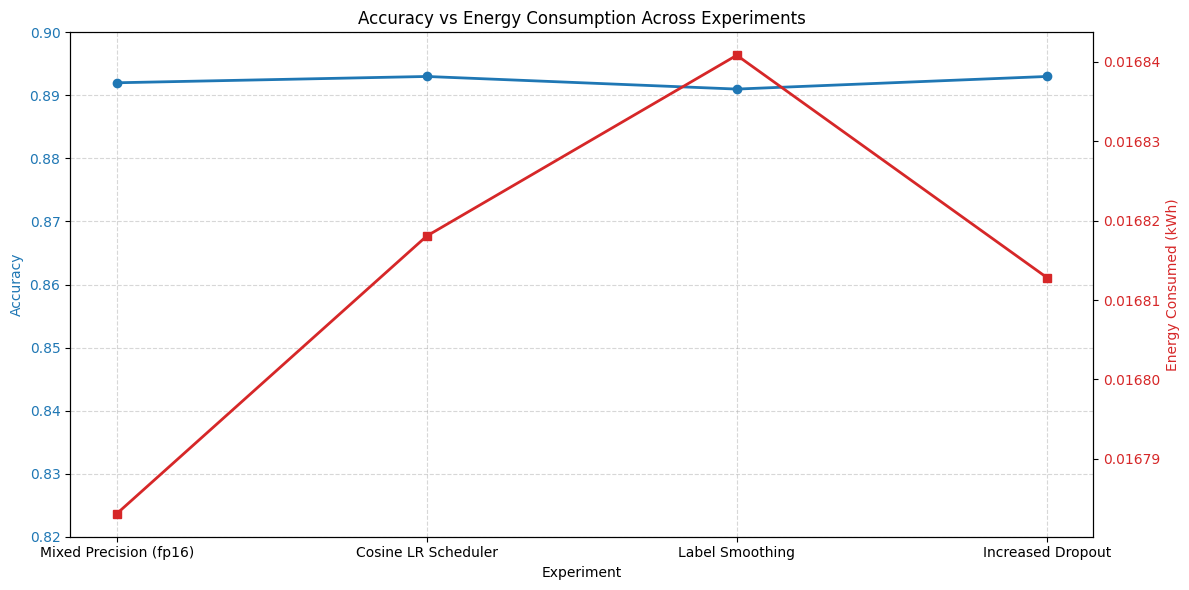

In [20]:
# --- Visualization of Accuracy & Energy for Available Experiments ---
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Only available experiments ---
results_files = {
    "Mixed Precision (fp16)": "results_fp16_summary.csv",
    "Cosine LR Scheduler": "results_lr_summary.csv",
    "Label Smoothing": "results_ls_summary.csv",
    "Increased Dropout": "results_dropout_summary.csv"
}

emissions_files = {
    "Mixed Precision (fp16)": "emissions_fp16.csv",
    "Cosine LR Scheduler": "emissions_lr.csv",
    "Label Smoothing": "emissions_ls.csv",
    "Increased Dropout": "emissions_dropout.csv"
}

# --- 2. Collect metrics ---
experiment_names = []
accuracies = []
energies = []

for exp, res_file in results_files.items():
    df_res = pd.read_csv(res_file)
    df_em = pd.read_csv(emissions_files[exp])
    
    experiment_names.append(exp)
    accuracies.append(df_res["Accuracy"].values[0])
    energies.append(df_em["energy_consumed"].sum())  # total energy in kWh

# --- 3. Plotting ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Accuracy line
color = 'tab:blue'
ax1.set_xlabel('Experiment')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(experiment_names, accuracies, marker='o', color=color, linewidth=2, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.82, 0.90)

# Energy line on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Energy Consumed (kWh)', color=color)
ax2.plot(experiment_names, energies, marker='s', color=color, linewidth=2, label='Energy')
ax2.tick_params(axis='y', labelcolor=color)

# Add titles and grid
plt.title("Accuracy vs Energy Consumption Across Experiments")
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()


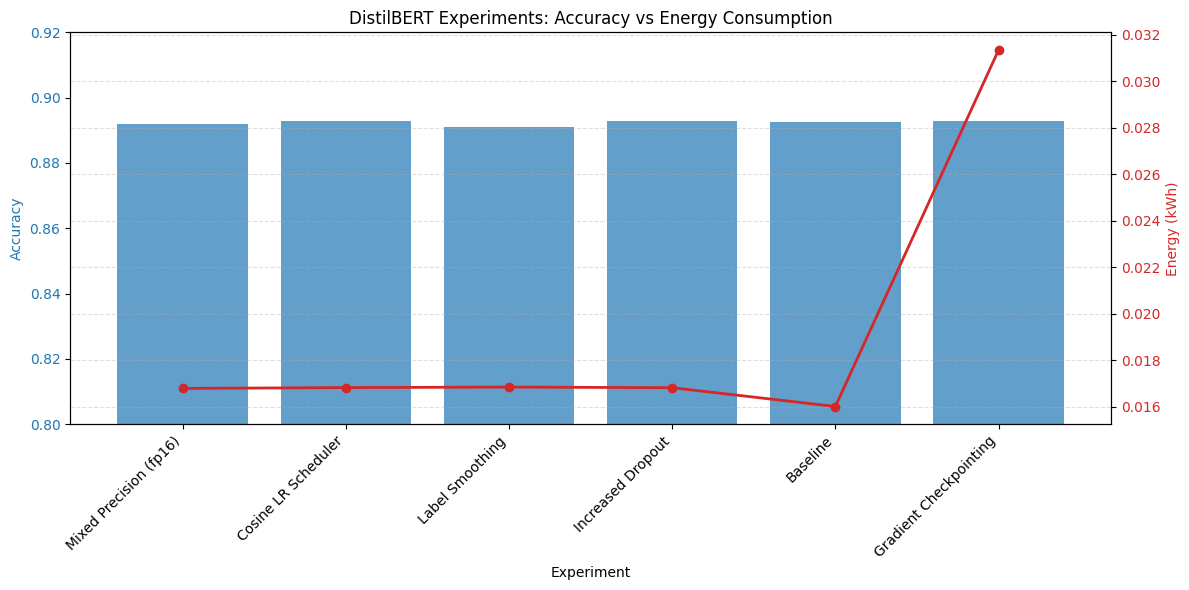

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Prepare the data ---

experiments = []

# Mixed Precision
experiments.append({
    "Experiment": "Mixed Precision (fp16)",
    "Accuracy": 0.892,  # from your results
    "Energy": 0.016783081
})

# Cosine LR
experiments.append({
    "Experiment": "Cosine LR Scheduler",
    "Accuracy": 0.893,
    "Energy": 0.016818063
})

# Label Smoothing
experiments.append({
    "Experiment": "Label Smoothing",
    "Accuracy": 0.891,
    "Energy": 0.01684083
})

# Increased Dropout
experiments.append({
    "Experiment": "Increased Dropout",
    "Accuracy": 0.893,
    "Energy": 0.016812839
})

# Baseline
experiments.append({
    "Experiment": "Baseline",
    "Accuracy": 0.8925,
    "Energy": 0.016003802
})

# Gradient Checkpointing
experiments.append({
    "Experiment": "Gradient Checkpointing",
    "Accuracy": 0.8930,
    "Energy": 0.031340463
})

# Convert to DataFrame
df = pd.DataFrame(experiments)

# --- 2. Plot Accuracy and Energy ---
fig, ax1 = plt.subplots(figsize=(12, 6))  # wider figure for spacing

color = 'tab:blue'
ax1.set_xlabel('Experiment')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(df["Experiment"], df["Accuracy"], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.8, 0.92)

# Rotate x-axis labels and align them
plt.xticks(rotation=45, ha='right')

# Second y-axis for energy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Energy (kWh)', color=color)
ax2.plot(df["Experiment"], df["Energy"], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("DistilBERT Experiments: Accuracy vs Energy Consumption")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
